In [1]:
import numpy as np
import pandas as pd
import json
import os

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import geopandas as gpd

# custom functions
from plotting_functions.corr_matrix import plot_corr
from plotting_functions.map_scatter import map_scatter

sns.set()

In [2]:
main_data = pd.read_csv('../data/main_dataset.csv')
main_data

,borough,neighborhood,longitude,latitude,population,restaurant_count,N,bars,bbq,breakfast_brunch,...,store,subway_station,supermarket,synagogue,taxi_stand,tourist_attraction,transit_station,travel_agency,university,veterinary_care
0,Bronx,Wakefield,-73.847201,40.894705,21242.0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bronx,Co-op City,-73.829939,40.874294,43752.0,12,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bronx,Eastchester,-73.827806,40.887556,11506.0,19,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bronx,Fieldston,-73.905643,40.895437,9287.0,9,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,Bronx,Riverdale,-73.912585,40.890834,9287.0,14,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,Manhattan,Hudson Yards,-74.000111,40.756658,23383.0,20,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
302,Queens,Hammels,-73.805530,40.587338,12295.0,17,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
303,Queens,Bayswater,-73.765968,40.611322,25029.0,0,1,0,0,0,...,0,0,0,0,0,0,0,2,0,0
304,Queens,Queensbridge,-73.945631,40.756091,6677.0,17,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0


In [3]:
old_data = pd.read_csv('../data/old_dataset.csv', index_col=0)
old_data

,id,borough,neighborhood,longitude,latitude,population,number_of_restaurants,average_review_count,average_restaurant_rating,average_price_level,yelp_category
0,nyu_2451_34572.1,Bronx,Wakefield,-73.847201,40.894705,21242.0,13,169,4.0,1,caribbean
1,nyu_2451_34572.2,Bronx,Co-op City,-73.829939,40.874294,43752.0,12,771,4.0,2,delis
2,nyu_2451_34572.3,Bronx,Eastchester,-73.827806,40.887556,11506.0,19,532,4.1,1,caribbean
3,nyu_2451_34572.4,Bronx,Fieldston,-73.905643,40.895437,9287.0,9,297,4.4,1,N
4,nyu_2451_34572.5,Bronx,Riverdale,-73.912585,40.890834,9287.0,14,319,4.0,2,burgers
...,...,...,...,...,...,...,...,...,...,...,...
301,nyu_2451_34572.302,Manhattan,Hudson Yards,-74.000111,40.756658,23383.0,20,848,4.3,2,newamerican
302,nyu_2451_34572.303,Queens,Hammels,-73.805530,40.587338,12295.0,17,257,4.3,2,chicken_wings
303,nyu_2451_34572.304,Queens,Bayswater,-73.765968,40.611322,25029.0,0,0,0.0,0,N
304,nyu_2451_34572.305,Queens,Queensbridge,-73.945631,40.756091,6677.0,17,222,4.1,2,tradamerican


In [4]:
# let's only take features that are interesting
old_data = old_data[['average_restaurant_rating', 'average_price_level']]
old_data

,average_restaurant_rating,average_price_level
0,4.0,1
1,4.0,2
2,4.1,1
3,4.4,1
4,4.0,2
...,...,...
301,4.3,2
302,4.3,2
303,0.0,0
304,4.1,2


In [5]:
# let's get our encoded yelp_types
yelp_types = pd.read_csv('../data/data/yelp_restaurant_type_counts.csv').drop('Unnamed: 0', axis=1)
yelp_types

,caribbean,breakfast_brunch,pizza,burgers,sandwiches,comfortfood,soulfood,grocery,cafes,chinese,...,airportlounges,surfshop,media,shavedice,pretzels,srilankan,southafrican,personalchefs,homedecor,syrian
0,4.0,2.0,2.0,1.0,3.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,1.0,4.0,3.0,2.0,5.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
302,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
304,0.0,3.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# New Features

In [6]:
geo_info = main_data.loc[:,:'population']
geo_info

,borough,neighborhood,longitude,latitude,population
0,Bronx,Wakefield,-73.847201,40.894705,21242.0
1,Bronx,Co-op City,-73.829939,40.874294,43752.0
2,Bronx,Eastchester,-73.827806,40.887556,11506.0
3,Bronx,Fieldston,-73.905643,40.895437,9287.0
4,Bronx,Riverdale,-73.912585,40.890834,9287.0
...,...,...,...,...,...
301,Manhattan,Hudson Yards,-74.000111,40.756658,23383.0
302,Queens,Hammels,-73.805530,40.587338,12295.0
303,Queens,Bayswater,-73.765968,40.611322,25029.0
304,Queens,Queensbridge,-73.945631,40.756091,6677.0


In [7]:
main_features = main_data.loc[:,'restaurant_count':]

In [8]:
# scaling
scaler = StandardScaler()
main_features_scaled = pd.DataFrame(scaler.fit_transform(main_features), columns=main_features.columns)
main_features_scaled

,restaurant_count,N,bars,bbq,breakfast_brunch,burgers,cafes,cantonese,caribbean,chicken_wings,...,store,subway_station,supermarket,synagogue,taxi_stand,tourist_attraction,transit_station,travel_agency,university,veterinary_care
0,-0.392302,-0.218964,-0.081111,-0.05726,-0.242536,-0.141421,-0.081111,-0.05726,3.683942,-0.057260,...,-0.640901,-0.05726,-0.318142,-0.236433,-0.05726,-0.342405,-0.213937,-0.299122,-0.200315,-0.183804
1,-0.490618,-0.218964,-0.081111,-0.05726,-0.242536,-0.141421,-0.081111,-0.05726,-0.271448,-0.057260,...,-0.640901,-0.05726,-0.318142,-0.236433,-0.05726,-0.342405,-0.213937,-0.299122,-0.200315,-0.183804
2,0.197597,-0.218964,-0.081111,-0.05726,-0.242536,-0.141421,-0.081111,-0.05726,3.683942,-0.057260,...,-0.640901,-0.05726,-0.318142,-0.236433,-0.05726,-0.342405,-0.213937,-0.299122,-0.200315,-0.183804
3,-0.785567,4.566962,-0.081111,-0.05726,-0.242536,-0.141421,-0.081111,-0.05726,-0.271448,-0.057260,...,-0.640901,-0.05726,-0.318142,3.782930,-0.05726,-0.342405,-0.213937,-0.299122,-0.200315,-0.183804
4,-0.293985,-0.218964,-0.081111,-0.05726,-0.242536,7.071068,-0.081111,-0.05726,-0.271448,-0.057260,...,-0.640901,-0.05726,-0.318142,7.802293,-0.05726,-0.342405,-0.213937,-0.299122,-0.200315,-0.183804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,0.295913,-0.218964,-0.081111,-0.05726,-0.242536,-0.141421,-0.081111,-0.05726,-0.271448,-0.057260,...,0.424945,-0.05726,-0.318142,-0.236433,-0.05726,-0.342405,-0.213937,-0.299122,-0.200315,-0.183804
302,0.000964,-0.218964,-0.081111,-0.05726,-0.242536,-0.141421,-0.081111,-0.05726,-0.271448,17.464249,...,-0.640901,-0.05726,-0.318142,-0.236433,-0.05726,-0.342405,-0.213937,-0.299122,-0.200315,-0.183804
303,-1.670415,4.566962,-0.081111,-0.05726,-0.242536,-0.141421,-0.081111,-0.05726,-0.271448,-0.057260,...,-0.640901,-0.05726,-0.318142,-0.236433,-0.05726,-0.342405,-0.213937,5.085066,-0.200315,-0.183804
304,0.000964,-0.218964,-0.081111,-0.05726,-0.242536,-0.141421,-0.081111,-0.05726,-0.271448,-0.057260,...,3.622484,-0.05726,-0.318142,-0.236433,-0.05726,-0.342405,-0.213937,-0.299122,-0.200315,-0.183804


In [9]:
# not ideal, let's add more features

features = pd.concat([main_features,yelp_types,old_data], axis=1)

In [10]:
# Let's try removing some less ideal features
features = features.drop(['N','restaurant_count','average_restaurant_rating','average_price_level'],axis=1)

In [11]:
# scaling
scaler = StandardScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
features_scaled

# # try MinMaxScaler
# scaler = MinMaxScaler()
# features_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
# features_scaled

,bars,bbq,breakfast_brunch,burgers,cafes,cantonese,caribbean,chicken_wings,chickenshop,chinese,...,airportlounges,surfshop,media,shavedice,pretzels,srilankan,southafrican,personalchefs,homedecor,syrian
0,-0.081111,-0.05726,-0.242536,-0.141421,-0.081111,-0.05726,3.683942,-0.057260,-0.05726,-0.298275,...,-0.05726,-0.05726,-0.081111,-0.081111,-0.081111,-0.092193,-0.05726,-0.05726,-0.081111,-0.05726
1,-0.081111,-0.05726,-0.242536,-0.141421,-0.081111,-0.05726,-0.271448,-0.057260,-0.05726,-0.298275,...,-0.05726,-0.05726,-0.081111,-0.081111,-0.081111,-0.092193,-0.05726,-0.05726,-0.081111,-0.05726
2,-0.081111,-0.05726,-0.242536,-0.141421,-0.081111,-0.05726,3.683942,-0.057260,-0.05726,-0.298275,...,-0.05726,-0.05726,-0.081111,-0.081111,-0.081111,-0.092193,-0.05726,-0.05726,-0.081111,-0.05726
3,-0.081111,-0.05726,-0.242536,-0.141421,-0.081111,-0.05726,-0.271448,-0.057260,-0.05726,-0.298275,...,-0.05726,-0.05726,-0.081111,-0.081111,-0.081111,-0.092193,-0.05726,-0.05726,-0.081111,-0.05726
4,-0.081111,-0.05726,-0.242536,7.071068,-0.081111,-0.05726,-0.271448,-0.057260,-0.05726,-0.298275,...,-0.05726,-0.05726,-0.081111,-0.081111,-0.081111,-0.092193,-0.05726,-0.05726,-0.081111,-0.05726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,-0.081111,-0.05726,-0.242536,-0.141421,-0.081111,-0.05726,-0.271448,-0.057260,-0.05726,-0.298275,...,-0.05726,-0.05726,-0.081111,12.328828,-0.081111,-0.092193,-0.05726,-0.05726,-0.081111,-0.05726
302,-0.081111,-0.05726,-0.242536,-0.141421,-0.081111,-0.05726,-0.271448,17.464249,-0.05726,-0.298275,...,-0.05726,-0.05726,-0.081111,-0.081111,-0.081111,-0.092193,-0.05726,-0.05726,-0.081111,-0.05726
303,-0.081111,-0.05726,-0.242536,-0.141421,-0.081111,-0.05726,-0.271448,-0.057260,-0.05726,-0.298275,...,-0.05726,-0.05726,-0.081111,-0.081111,-0.081111,-0.092193,-0.05726,-0.05726,-0.081111,-0.05726
304,-0.081111,-0.05726,-0.242536,-0.141421,-0.081111,-0.05726,-0.271448,-0.057260,-0.05726,-0.298275,...,-0.05726,-0.05726,-0.081111,-0.081111,-0.081111,-0.092193,-0.05726,-0.05726,-0.081111,-0.05726


In [12]:
# Let's figure out the best value for eps
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(features_scaled)

distances, indices = nbrs.kneighbors(features_scaled)

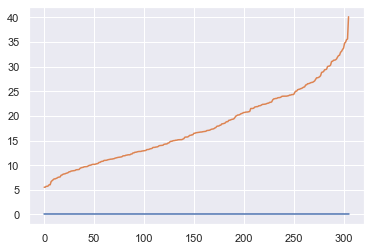

In [13]:
# plot it
distances = np.sort(distances, axis=0)
plt.plot(distances)

In [14]:
# between 0.5 and 1.0 seems best
dbscan = DBSCAN(
    eps=35,
    min_samples=10,
    n_jobs=-1
)

In [15]:
# fit and predict
clusters = pd.Series(dbscan.fit_predict(features_scaled))
clusters.nunique()

2

# This isn't really working, let's try PCA

In [16]:
# remove restaurant count
features_scaled

,bars,bbq,breakfast_brunch,burgers,cafes,cantonese,caribbean,chicken_wings,chickenshop,chinese,...,airportlounges,surfshop,media,shavedice,pretzels,srilankan,southafrican,personalchefs,homedecor,syrian
0,-0.081111,-0.05726,-0.242536,-0.141421,-0.081111,-0.05726,3.683942,-0.057260,-0.05726,-0.298275,...,-0.05726,-0.05726,-0.081111,-0.081111,-0.081111,-0.092193,-0.05726,-0.05726,-0.081111,-0.05726
1,-0.081111,-0.05726,-0.242536,-0.141421,-0.081111,-0.05726,-0.271448,-0.057260,-0.05726,-0.298275,...,-0.05726,-0.05726,-0.081111,-0.081111,-0.081111,-0.092193,-0.05726,-0.05726,-0.081111,-0.05726
2,-0.081111,-0.05726,-0.242536,-0.141421,-0.081111,-0.05726,3.683942,-0.057260,-0.05726,-0.298275,...,-0.05726,-0.05726,-0.081111,-0.081111,-0.081111,-0.092193,-0.05726,-0.05726,-0.081111,-0.05726
3,-0.081111,-0.05726,-0.242536,-0.141421,-0.081111,-0.05726,-0.271448,-0.057260,-0.05726,-0.298275,...,-0.05726,-0.05726,-0.081111,-0.081111,-0.081111,-0.092193,-0.05726,-0.05726,-0.081111,-0.05726
4,-0.081111,-0.05726,-0.242536,7.071068,-0.081111,-0.05726,-0.271448,-0.057260,-0.05726,-0.298275,...,-0.05726,-0.05726,-0.081111,-0.081111,-0.081111,-0.092193,-0.05726,-0.05726,-0.081111,-0.05726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,-0.081111,-0.05726,-0.242536,-0.141421,-0.081111,-0.05726,-0.271448,-0.057260,-0.05726,-0.298275,...,-0.05726,-0.05726,-0.081111,12.328828,-0.081111,-0.092193,-0.05726,-0.05726,-0.081111,-0.05726
302,-0.081111,-0.05726,-0.242536,-0.141421,-0.081111,-0.05726,-0.271448,17.464249,-0.05726,-0.298275,...,-0.05726,-0.05726,-0.081111,-0.081111,-0.081111,-0.092193,-0.05726,-0.05726,-0.081111,-0.05726
303,-0.081111,-0.05726,-0.242536,-0.141421,-0.081111,-0.05726,-0.271448,-0.057260,-0.05726,-0.298275,...,-0.05726,-0.05726,-0.081111,-0.081111,-0.081111,-0.092193,-0.05726,-0.05726,-0.081111,-0.05726
304,-0.081111,-0.05726,-0.242536,-0.141421,-0.081111,-0.05726,-0.271448,-0.057260,-0.05726,-0.298275,...,-0.05726,-0.05726,-0.081111,-0.081111,-0.081111,-0.092193,-0.05726,-0.05726,-0.081111,-0.05726


Text(0, 0.5, 'Variance Explained')

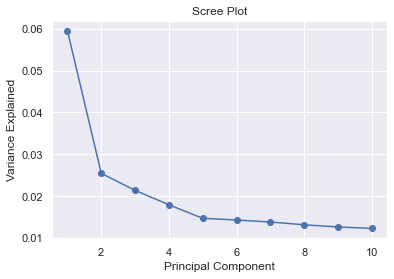

In [17]:
# How many PCs do we want?

pca = PCA(n_components=10)
pca_fit = pca.fit(features_scaled)
pca_fit

PC_values = np.arange(pca.n_components_) + 1
PC_values

plt.plot(PC_values, pca.explained_variance_ratio_, 'o-')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')

In [18]:
# 3 is the ideal PCA
pca = PCA(n_components=3)
features_pca = pd.DataFrame(pca.fit_transform(features_scaled), columns=['PC1','PC2','PC3'])
features_pca

# # Let's try 5
# pca = PCA(n_components=5)
# features_pca = pd.DataFrame(pca.fit_transform(features_scaled), columns=['PC1','PC2','PC3','PC4','PC5'])
# features_pca

,PC1,PC2,PC3
0,-3.719006,0.891275,-0.730744
1,-4.031917,0.652034,0.068637
2,-3.743484,0.822438,-1.386917
3,-4.466648,2.128319,-1.030878
4,-2.387189,0.928239,-0.489059
...,...,...,...
301,7.879967,-0.532664,-1.791089
302,-3.992846,1.040376,-1.170375
303,-4.340139,1.840117,-1.349975
304,-0.686059,-0.709019,-0.912492


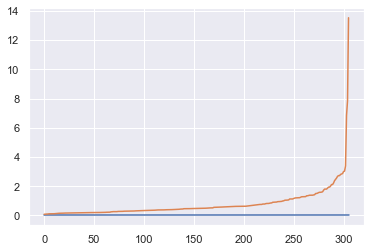

In [19]:
# Let's figure out the best value for eps
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(features_pca)

distances, indices = nbrs.kneighbors(features_pca)

# plot it
distances = np.sort(distances, axis=0)
plt.plot(distances)

In [20]:
dbscan = DBSCAN(
    eps=1.5,
    min_samples=3,
    n_jobs=-1
)

In [21]:
# fit and predict
clusters = pd.Series(dbscan.fit_predict(features_pca))
clusters.nunique()

7

In [22]:
# add back geo info and clusters
clustered_pca = pd.concat([geo_info, features_pca, clusters], axis=1)
clustered_pca = clustered_pca.rename(columns={0:'cluster'})

In [23]:
clustered_pca

,borough,neighborhood,longitude,latitude,population,PC1,PC2,PC3,cluster
0,Bronx,Wakefield,-73.847201,40.894705,21242.0,-3.719006,0.891275,-0.730744,0
1,Bronx,Co-op City,-73.829939,40.874294,43752.0,-4.031917,0.652034,0.068637,0
2,Bronx,Eastchester,-73.827806,40.887556,11506.0,-3.743484,0.822438,-1.386917,0
3,Bronx,Fieldston,-73.905643,40.895437,9287.0,-4.466648,2.128319,-1.030878,0
4,Bronx,Riverdale,-73.912585,40.890834,9287.0,-2.387189,0.928239,-0.489059,0
...,...,...,...,...,...,...,...,...,...
301,Manhattan,Hudson Yards,-74.000111,40.756658,23383.0,7.879967,-0.532664,-1.791089,2
302,Queens,Hammels,-73.805530,40.587338,12295.0,-3.992846,1.040376,-1.170375,0
303,Queens,Bayswater,-73.765968,40.611322,25029.0,-4.340139,1.840117,-1.349975,0
304,Queens,Queensbridge,-73.945631,40.756091,6677.0,-0.686059,-0.709019,-0.912492,0


In [24]:
def DBSCANplot(data=features_pca, eps=2, min_samples=3, map_plot=True):
    dbscan = DBSCAN(
    eps=eps,
    min_samples=min_samples,
    n_jobs=-1
    )
    
    # fit and predict
    clusters = pd.Series(dbscan.fit_predict(data))
    print(clusters.nunique())

    # add back geo info and clusters
    clustered_pca = pd.concat([geo_info, features_pca, clusters], axis=1)
    clustered_pca = clustered_pca.rename(columns={0:'cluster'})

    if map_plot:
        map_scatter(clustered_pca)


    # reduce to 3D for graphing
    pca = PCA(n_components=3)
    graph_pca = pd.DataFrame(pca.fit_transform(features_scaled), columns=['PC1','PC2','PC3'])
    graph_pca = pd.concat([graph_pca,clusters], axis=1)
    graph_pca = graph_pca.rename(columns={0:'cluster'})


    fig = px.scatter_3d(graph_pca, x='PC1', y='PC2', z='PC3',
              color='cluster')
    fig.show()

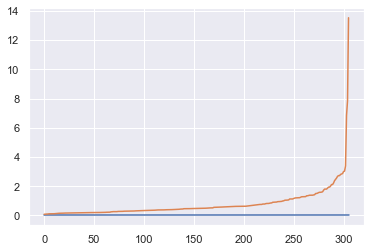

In [25]:
# Let's figure out the best value for eps
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(features_pca)

distances, indices = nbrs.kneighbors(features_pca)

# plot it
distances = np.sort(distances, axis=0)
plt.plot(distances)

In [26]:
# Define variable options
eps_options = np.arange(0.5,1.5,0.1)
min_options = np.arange(4,6,1)

In [27]:
# for eps in eps_options:
#     for min in min_options:
#         print('eps:' + str(eps))
#         print('min:' + str(min))
#         DBSCANplot(features_pca, eps, min, map_plot=False)

In [28]:
# With PC3, best values are eps:1.6 and min 4
DBSCANplot(features_pca, 1.6,4)

8


In [29]:
num_top_venues = 5

# We need to remove the venue counts, it's distorting the data

### Google

In [30]:
# cleaning
print(main_features.columns.tolist())

['restaurant_count', 'N', 'bars', 'bbq', 'breakfast_brunch', 'burgers', 'cafes', 'cantonese', 'caribbean', 'chicken_wings', 'chickenshop', 'chinese', 'cocktailbars', 'coffee', 'colombian', 'delis', 'diners', 'dominican', 'foodtrucks', 'greek', 'halal', 'hotdogs', 'indpak', 'italian', 'juicebars', 'korean', 'kosher', 'latin', 'mediterranean', 'mexican', 'newamerican', 'pizza', 'russian', 'sandwiches', 'seafood', 'spanish', 'steak', 'sushi', 'tapasmallplates', 'thai', 'tradamerican', 'accounting', 'art_gallery', 'bakery', 'bank', 'bar', 'beauty_salon', 'bicycle_store', 'book_store', 'bowling_alley', 'bus_station', 'cafe', 'campground', 'car_dealer', 'car_rental', 'car_repair', 'car_wash', 'cemetery', 'church', 'city_hall', 'clothing_store', 'convenience_store', 'courthouse', 'dentist', 'department_store', 'doctor', 'drugstore', 'electrician', 'electronics_store', 'embassy', 'fire_station', 'florist', 'funeral_home', 'furniture_store', 'gas_station', 'general_contractor', 'grocery_or_supe

In [31]:
venue_features = main_features.drop(['restaurant_count','N'], axis=1)

In [32]:
venue_features

,bars,bbq,breakfast_brunch,burgers,cafes,cantonese,caribbean,chicken_wings,chickenshop,chinese,...,store,subway_station,supermarket,synagogue,taxi_stand,tourist_attraction,transit_station,travel_agency,university,veterinary_care
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
302,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
303,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
304,0,0,0,0,0,0,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0


In [33]:
num_top_venues = 5
indicators = ['st', 'nd', 'rd']

In [34]:
venue_freq = venue_features.copy()
venue_freq['neighborhood'] = geo_info['neighborhood'] 
venue_freq

fixed_columns = [venue_freq.columns[-1]] + list(venue_freq.columns[:-1])
venue_freq = venue_freq[fixed_columns]
venue_freq.head()

,neighborhood,bars,bbq,breakfast_brunch,burgers,cafes,cantonese,caribbean,chicken_wings,chickenshop,...,store,subway_station,supermarket,synagogue,taxi_stand,tourist_attraction,transit_station,travel_agency,university,veterinary_care
0,Wakefield,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Co-op City,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Eastchester,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Fieldston,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,Riverdale,0,0,0,1,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0


In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [36]:
# create columns according to number of top venues
columns = ['neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['neighborhood'] = venue_freq['neighborhood']
for ind in np.arange(venue_freq.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venue_freq.iloc[ind, :], num_top_venues)

In [37]:
neighborhoods_venues_sorted2 = neighborhoods_venues_sorted.copy()
neighborhoods_venues_sorted.head()

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Wakefield,school,church,doctor,general_contractor,laundry
1,Co-op City,doctor,dentist,local_government_office,health,secondary_school
2,Eastchester,general_contractor,car_repair,car_dealer,electronics_store,storage
3,Fieldston,health,church,lawyer,home_goods_store,school
4,Riverdale,doctor,real_estate_agency,health,dentist,synagogue


In [38]:
venue_clustering = venue_freq.drop('neighborhood', axis=1)

In [39]:
venue_clustering

,bars,bbq,breakfast_brunch,burgers,cafes,cantonese,caribbean,chicken_wings,chickenshop,chinese,...,store,subway_station,supermarket,synagogue,taxi_stand,tourist_attraction,transit_station,travel_agency,university,veterinary_care
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
302,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
303,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
304,0,0,0,0,0,0,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
